In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn

import train_datamaps_inprogress as train

from train import eval_func

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_rrnn(convai_train,['about','to','as'],word_to_index) 
convai_val_token = generic.tokenize_dataset_rrnn(convai_val,['about','to','as'],word_to_index) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_rrnn(md_data,['about','to','as'],word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True)

# Creación dataloaders

In [10]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [11]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [12]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn)

In [13]:
emb_dim = 100
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

## ABOUT

In [14]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6794428412091856 	 Validation loss: 0.6729293213052264 	 
  1%|          | 574/57400 [00:13<11:20, 83.53it/s]
Epoch 2 	 Training loss: 0.6355723345113549 	 Validation loss: 0.6163774072113684 	 
  2%|▏         | 1148/57400 [00:20<10:55, 85.79it/s]
Epoch 3 	 Training loss: 0.5953326962031554 	 Validation loss: 0.5857737468460859 	 
  3%|▎         | 1722/57400 [00:27<10:39, 87.10it/s]
Epoch 4 	 Training loss: 0.5666717565018126 	 Validation loss: 0.5642469934487747 	 
  4%|▍         | 2296/57400 [00:34<10:43, 85.68it/s]
Epoch 5 	 Training loss: 0.5433660779369002 	 Validation loss: 0.5515383416313236 	 
  5%|▌         | 2870/57400 [00:40<10:45, 84.46it/s]
Epoch 6 	 Training loss: 0.5215803521850798 	 Validation loss: 0.529942684759528 	 
  6%|▌         | 3444/57400 [00:47<10:56, 82.15it/s]
Epoch 7 	 Training loss: 0.5039080778065459 	 Validation loss: 0.5204166148678732 	 
  7%|▋         | 4018/57400 [00:54<10:08, 87.73it/s]
Epoch 8 	 Training loss: 0.487682817

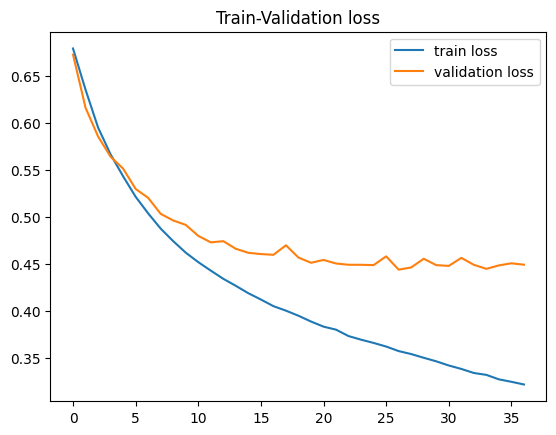

In [15]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [16]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.3875, 'male': 0.9322916666666666, 'average': 0.6598958333333333}
precision {'female': 0.856353591160221, 'male': 0.593698175787728, 'average': 0.7250258834739745}
f1 {'female': 0.5335628227194492, 'male': 0.7254305977710231, 'average': 0.6294967102452362}
accuracy 0.6543367346938775


Evaluación en el conjunto el conjunto to
recall {'female': 0.23097112860892388, 'male': 0.8223844282238443, 'average': 0.5266777784163841}
precision {'female': 0.546583850931677, 'male': 0.5356576862123613, 'average': 0.5411207685720192}
f1 {'female': 0.3247232472324723, 'male': 0.6487523992322457, 'average': 0.48673782323235903}
accuracy 0.5378787878787878


Evaluación en el conjunto el conjunto as
recall {'female': 0.25336927223719674, 'male': 0.8585858585858586, 'average': 0.5559775654115277}
precision {'female': 0.6266666666666667, 'male': 0.5510534846029174, 'average': 0.588860075634792}
f1 {'female': 0.3608445297504798, 'male': 0.6712

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.676596138120113 	 Validation loss: 0.6636082742173793 	 
  1%|          | 574/57400 [00:06<10:58, 86.23it/s]
Epoch 2 	 Training loss: 0.6312028292164155 	 Validation loss: 0.6166780964802887 	 
  2%|▏         | 1148/57400 [00:13<11:11, 83.79it/s]
Epoch 3 	 Training loss: 0.5932046388915192 	 Validation loss: 0.582185115854619 	 
  3%|▎         | 1722/57400 [00:20<10:55, 84.95it/s]
Epoch 4 	 Training loss: 0.5647663564943686 	 Validation loss: 0.5646059129197719 	 
  4%|▍         | 2296/57400 [00:27<10:43, 85.63it/s]
Epoch 5 	 Training loss: 0.5398527465838588 	 Validation loss: 0.5444187870470144 	 
  5%|▌         | 2870/57400 [00:34<10:40, 85.14it/s]
Epoch 6 	 Training loss: 0.5174663079324915 	 Validation loss: 0.5290966943158941 	 
  6%|▌         | 3444/57400 [00:40<10:26, 86.16it/s]
Epoch 7 	 Training loss: 0.49828539632961727 	 Validation loss: 0.5218178230827137 	 
  7%|▋         | 4018/57400 [00:47<10:25, 85.38it/s]
Epoch 8 	 Training loss: 0.483454773

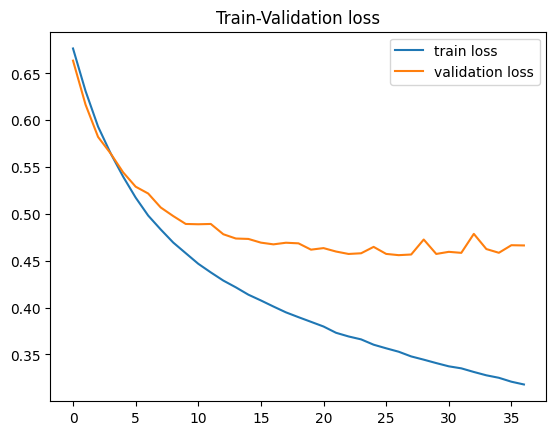

In [17]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [18]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.3825, 'male': 0.9453125, 'average': 0.66390625}
precision {'female': 0.8793103448275862, 'male': 0.5950819672131148, 'average': 0.7371961560203505}
f1 {'female': 0.5331010452961673, 'male': 0.7303822937625755, 'average': 0.6317416695293714}
accuracy 0.6581632653061225


Evaluación en el conjunto el conjunto to
recall {'female': 0.2152230971128609, 'male': 0.8394160583941606, 'average': 0.5273195777535107}
precision {'female': 0.5540540540540541, 'male': 0.5357142857142857, 'average': 0.5448841698841699}
f1 {'female': 0.31001890359168244, 'male': 0.6540284360189574, 'average': 0.48202366980531997}
accuracy 0.5391414141414141


Evaluación en el conjunto el conjunto as
recall {'female': 0.18867924528301888, 'male': 0.8888888888888888, 'average': 0.5387840670859538}
precision {'female': 0.6140350877192983, 'male': 0.5390505359877489, 'average': 0.5765428118535236}
f1 {'female': 0.28865979381443296, 'male': 0.671115347950429,

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.677703765211205 	 Validation loss: 0.6701054633673975 	 
  1%|          | 574/57400 [00:06<10:51, 87.18it/s]
Epoch 2 	 Training loss: 0.635791612315261 	 Validation loss: 0.6139240254790096 	 
  2%|▏         | 1148/57400 [00:13<10:44, 87.25it/s]
Epoch 3 	 Training loss: 0.595657070079747 	 Validation loss: 0.5856820870253999 	 
  3%|▎         | 1722/57400 [00:20<11:02, 84.01it/s]
Epoch 4 	 Training loss: 0.5647731633136497 	 Validation loss: 0.5641904215691453 	 
  4%|▍         | 2296/57400 [00:26<10:33, 86.93it/s]
Epoch 5 	 Training loss: 0.5385209455411193 	 Validation loss: 0.5463087609258749 	 
  5%|▌         | 2870/57400 [00:33<10:29, 86.56it/s]
Epoch 6 	 Training loss: 0.5151408023431326 	 Validation loss: 0.5281523385290372 	 
  6%|▌         | 3444/57400 [00:40<10:25, 86.28it/s]
Epoch 7 	 Training loss: 0.4958974980726475 	 Validation loss: 0.5169905696885061 	 
  7%|▋         | 4018/57400 [00:47<10:08, 87.77it/s]
Epoch 8 	 Training loss: 0.47928000939

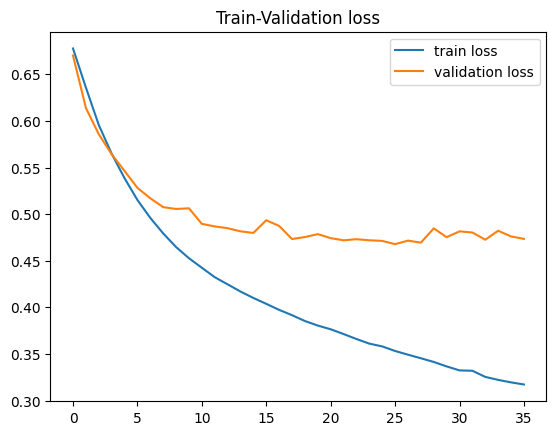

In [19]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [20]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.95, 'male': 0.2630208333333333, 'average': 0.6065104166666666}
precision {'female': 0.5731523378582202, 'male': 0.8347107438016529, 'average': 0.7039315408299365}
f1 {'female': 0.7149576669802445, 'male': 0.39999999999999997, 'average': 0.5574788334901223}
accuracy 0.6135204081632653


Evaluación en el conjunto el conjunto to
recall {'female': 0.9081364829396326, 'male': 0.12165450121654502, 'average': 0.5148954920780888}
precision {'female': 0.4893917963224894, 'male': 0.5882352941176471, 'average': 0.5388135452200682}
f1 {'female': 0.636029411764706, 'male': 0.2016129032258065, 'average': 0.4188211574952562}
accuracy 0.5


Evaluación en el conjunto el conjunto as
recall {'female': 0.9380053908355795, 'male': 0.14898989898989898, 'average': 0.5434976449127392}
precision {'female': 0.5080291970802919, 'male': 0.7195121951219512, 'average': 0.6137706961011216}
f1 {'female': 0.6590909090909091, 'male': 0.24686192468619245,

In [21]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.6062390710882433
f1 etiqueta male: 0.6186042971778662
f1 etiqueta female:  0.5938738449986204


TO
Resultado global f1: 0.4625275501776451
f1 etiqueta male: 0.5014645794923366
f1 etiqueta female:  0.42359052086295357


AS
Resultado global f1: 0.48297432508411403
f1 etiqueta male: 0.5297502392829541
f1 etiqueta female:  0.43619841088527395


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.6434375
recall etiqueta male: 0.7135416666666666
recall etiqueta female:  0.5733333333333334


TO
Resultado global recall: 0.5229642827493278
recall etiqueta male: 0.5944849959448499
recall etiqueta female:  0.45144356955380577


AS
Resultado global recall: 0.5460864258034069
recall etiqueta male: 0.6321548821548821
recall etiqueta female:  0.46001796945193174


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.7220511934414204
precision etiqueta male: 0.6744969622674986
precision etiqueta female:  0.76960

## TO

In [22]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933627386126369 	 Validation loss: 0.691546637122914 	 
  1%|          | 574/57400 [00:07<12:02, 78.67it/s]
Epoch 2 	 Training loss: 0.6934626054680721 	 Validation loss: 0.6932067002280283 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:14<11:26, 81.95it/s]
Epoch 3 	 Training loss: 0.6931705624384332 	 Validation loss: 0.6943795731512167 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:22<11:26, 81.16it/s]
Epoch 4 	 Training loss: 0.6931232235780577 	 Validation loss: 0.6940127984952118 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:29<11:17, 81.39it/s]
Epoch 5 	 Training loss: 0.6931624827899999 	 Validation loss: 0.6925899931939982 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:36<11:12, 81.03it/s]
Epoch 6 	 Training loss: 0.6929548444025192 	 Validation loss: 0.6927588036504843 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:43<11:10, 80.47it/s]
Epoch 7 	 Training loss: 0.69

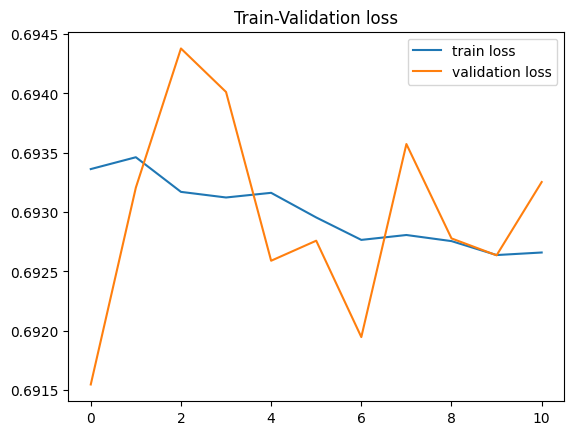

In [23]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [24]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.515, 'male': 0.4921875, 'average': 0.5035937500000001}
precision {'female': 0.513715710723192, 'male': 0.4934725848563969, 'average': 0.5035941477897945}
f1 {'female': 0.5143570536828964, 'male': 0.49282920469361147, 'average': 0.5035931291882539}
accuracy 0.5038265306122449


Evaluación en el conjunto el conjunto to
recall {'female': 0.49343832020997375, 'male': 0.5620437956204379, 'average': 0.5277410579152059}
precision {'female': 0.5108695652173914, 'male': 0.5448113207547169, 'average': 0.5278404429860541}
f1 {'female': 0.5020026702269693, 'male': 0.5532934131736528, 'average': 0.5276480417003111}
accuracy 0.5290404040404041


Evaluación en el conjunto el conjunto as
recall {'female': 0.4743935309973046, 'male': 0.5732323232323232, 'average': 0.5238129271148139}
precision {'female': 0.5101449275362319, 'male': 0.5379146919431279, 'average': 0.5240298097396798}
f1 {'female': 0.49162011173184356, 'male': 0.55501222493

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6935935604032324 	 Validation loss: 0.6927529765387713 	 
  1%|          | 574/57400 [00:07<11:35, 81.69it/s]
Epoch 2 	 Training loss: 0.6931538381435315 	 Validation loss: 0.6940368060338296 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:14<11:24, 82.15it/s]
Epoch 3 	 Training loss: 0.6932696444647652 	 Validation loss: 0.6934631820452415 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:21<11:18, 82.02it/s]
Epoch 4 	 Training loss: 0.6930995091328638 	 Validation loss: 0.6930045030884824 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:29<11:41, 78.61it/s]
Epoch 5 	 Training loss: 0.6929283735021066 	 Validation loss: 0.6935453950348547 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:36<11:05, 81.89it/s]
Epoch 6 	 Training loss: 0.6929756027065503 	 Validation loss: 0.6931031710010463 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:43<11:25, 78.70it/s]
Epoch 7 	 Training loss: 0.6

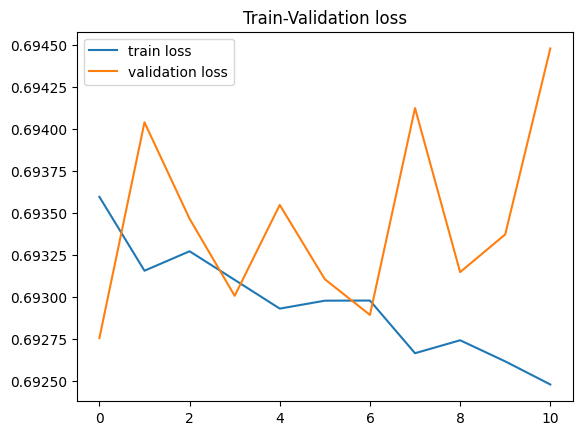

In [25]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [26]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.92, 'male': 0.08854166666666667, 'average': 0.5042708333333333}
precision {'female': 0.5125348189415042, 'male': 0.5151515151515151, 'average': 0.5138431670465097}
f1 {'female': 0.6583184257602862, 'male': 0.1511111111111111, 'average': 0.40471476843569865}
accuracy 0.5127551020408163


Evaluación en el conjunto el conjunto to
recall {'female': 0.9448818897637795, 'male': 0.06569343065693431, 'average': 0.5052876602103569}
precision {'female': 0.4838709677419355, 'male': 0.5625, 'average': 0.5231854838709677}
f1 {'female': 0.6399999999999999, 'male': 0.11764705882352941, 'average': 0.37882352941176467}
accuracy 0.48863636363636365


Evaluación en el conjunto el conjunto as
recall {'female': 0.9137466307277629, 'male': 0.05303030303030303, 'average': 0.4833884668790329}
precision {'female': 0.47478991596638653, 'male': 0.39622641509433965, 'average': 0.4355081655303631}
f1 {'female': 0.6248847926267281, 'male': 0.09354120

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6937204138327143 	 Validation loss: 0.6929909344446861 	 
  1%|          | 574/57400 [00:07<11:41, 80.99it/s]
Epoch 2 	 Training loss: 0.6934138358885403 	 Validation loss: 0.6921228382547023 	 
  2%|▏         | 1148/57400 [00:14<11:39, 80.42it/s]
Epoch 3 	 Training loss: 0.6932548980264298 	 Validation loss: 0.6924623857110234 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:22<11:22, 81.54it/s]
Epoch 4 	 Training loss: 0.6930595958274416 	 Validation loss: 0.6935468184745918 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:29<11:07, 82.50it/s]
Epoch 5 	 Training loss: 0.6929731122915753 	 Validation loss: 0.6934309066352198 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:36<11:11, 81.24it/s]
Epoch 6 	 Training loss: 0.6929431525464672 	 Validation loss: 0.6920954756817576 	 
  6%|▌         | 3444/57400 [00:44<11:20, 79.34it/s]
Epoch 7 	 Training loss: 0.6929304433616612 	 Validation loss: 0.693887849985543 	 

1

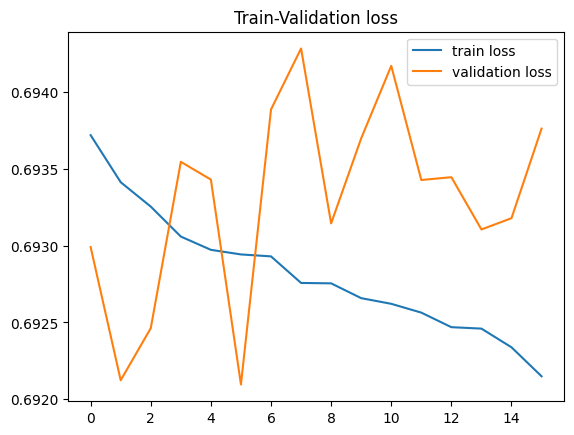

In [27]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [28]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.8925, 'male': 0.125, 'average': 0.50875}
precision {'female': 0.5151515151515151, 'male': 0.5274725274725275, 'average': 0.5213120213120213}
f1 {'female': 0.6532479414455625, 'male': 0.20210526315789473, 'average': 0.42767660230172866}
accuracy 0.5165816326530612


Evaluación en el conjunto el conjunto to
recall {'female': 0.8871391076115486, 'male': 0.09002433090024331, 'average': 0.48858171925589594}
precision {'female': 0.4747191011235955, 'male': 0.4625, 'average': 0.46860955056179776}
f1 {'female': 0.6184812442817932, 'male': 0.15071283095723012, 'average': 0.38459703761951164}
accuracy 0.4734848484848485


Evaluación en el conjunto el conjunto as
recall {'female': 0.9083557951482479, 'male': 0.09848484848484848, 'average': 0.5034203218165482}
precision {'female': 0.48559077809798273, 'male': 0.5342465753424658, 'average': 0.5099186767202243}
f1 {'female': 0.6328638497652582, 'male': 0.16631130063965885, 'average': 

In [29]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.44532816664189373
f1 etiqueta male: 0.2820151929875391
f1 etiqueta female:  0.6086411402962484


TO
Resultado global f1: 0.4303562029105291
f1 etiqueta male: 0.2738844343181374
f1 etiqueta female:  0.5868279715029208


AS
Resultado global f1: 0.427372247062495
f1 etiqueta male: 0.27162157608371335
f1 etiqueta female:  0.5831229180412767


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.5055381944444445
recall etiqueta male: 0.23524305555555555
recall etiqueta female:  0.7758333333333334


TO
Resultado global recall: 0.5072034791271529
recall etiqueta male: 0.23925385239253852
recall etiqueta female:  0.7751531058617673


AS
Resultado global recall: 0.5035405719367984
recall etiqueta male: 0.24158249158249157
recall etiqueta female:  0.7654986522911051


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.5129164453827751
precision etiqueta male: 0.5120322091601465
precision etiqueta female: 

## AS

In [30]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693395045056991 	 Validation loss: 0.6926209451788563 	 
  1%|          | 574/57400 [00:07<11:34, 81.79it/s]
Epoch 2 	 Training loss: 0.6930881247495525 	 Validation loss: 0.6941503185336872 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:14<11:27, 81.84it/s]
Epoch 3 	 Training loss: 0.6928749312922514 	 Validation loss: 0.6939507318755328 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:22<11:22, 81.52it/s]
Epoch 4 	 Training loss: 0.6929079298358346 	 Validation loss: 0.6931697897991892 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:29<11:11, 82.02it/s]
Epoch 5 	 Training loss: 0.692681380161425 	 Validation loss: 0.6935917411820364 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:36<11:04, 82.10it/s]
Epoch 6 	 Training loss: 0.6923682582710678 	 Validation loss: 0.6924563383651992 	 
  6%|▌         | 3444/57400 [00:43<11:18, 79.47it/s]
Epoch 7 	 Training loss: 0.6918425312856349 	 Validation lo

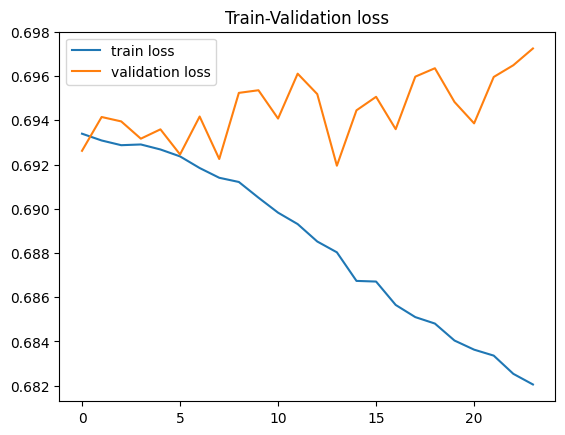

In [31]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [32]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.175, 'male': 0.7708333333333334, 'average': 0.47291666666666665}
precision {'female': 0.4430379746835443, 'male': 0.4728434504792332, 'average': 0.45794071258138874}
f1 {'female': 0.25089605734767023, 'male': 0.5861386138613861, 'average': 0.4185173356045282}
accuracy 0.46683673469387754


Evaluación en el conjunto el conjunto to
recall {'female': 0.1968503937007874, 'male': 0.8248175182481752, 'average': 0.5108339559744813}
precision {'female': 0.5102040816326531, 'male': 0.5255813953488372, 'average': 0.5178927384907451}
f1 {'female': 0.2840909090909091, 'male': 0.6420454545454545, 'average': 0.46306818181818177}
accuracy 0.5227272727272727


Evaluación en el conjunto el conjunto as
recall {'female': 0.20215633423180593, 'male': 0.8232323232323232, 'average': 0.5126943287320646}
precision {'female': 0.5172413793103449, 'male': 0.5241157556270096, 'average': 0.5206785674686772}
f1 {'female': 0.29069767441860467, 'male':

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6934750601389682 	 Validation loss: 0.6930891467353045 	 
  1%|          | 574/57400 [00:07<11:29, 82.46it/s]
Epoch 2 	 Training loss: 0.693170411557686 	 Validation loss: 0.6938082343440944 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:14<11:29, 81.56it/s]
Epoch 3 	 Training loss: 0.6931778167598339 	 Validation loss: 0.693235205391706 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:21<11:15, 82.40it/s]
Epoch 4 	 Training loss: 0.6927154520039774 	 Validation loss: 0.6941291265568491 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:29<11:09, 82.31it/s]
Epoch 5 	 Training loss: 0.6926880030266499 	 Validation loss: 0.6920664957014181 	 
  5%|▌         | 2870/57400 [00:36<11:33, 78.69it/s]
Epoch 6 	 Training loss: 0.6924975215350294 	 Validation loss: 0.6932495933468059 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:43<11:06, 80.91it/s]
Epoch 7 	 Training loss: 0.6921792036564923 	 Validation lo

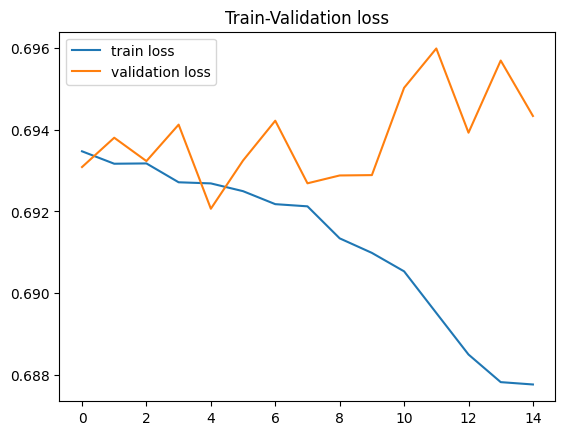

In [33]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [34]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.96, 'male': 0.036458333333333336, 'average': 0.49822916666666667}
precision {'female': 0.5092838196286472, 'male': 0.4666666666666667, 'average': 0.48797524314765695}
f1 {'female': 0.6655112651646448, 'male': 0.0676328502415459, 'average': 0.3665720577030953}
accuracy 0.5076530612244898


Evaluación en el conjunto el conjunto to
recall {'female': 0.9711286089238845, 'male': 0.024330900243309004, 'average': 0.49772975458359675}
precision {'female': 0.4798962386511025, 'male': 0.47619047619047616, 'average': 0.4780433574207893}
f1 {'female': 0.6423611111111112, 'male': 0.0462962962962963, 'average': 0.3443287037037037}
accuracy 0.4797979797979798


Evaluación en el conjunto el conjunto as
recall {'female': 0.9703504043126685, 'male': 0.03787878787878788, 'average': 0.5041145960957282}
precision {'female': 0.48582995951417, 'male': 0.5769230769230769, 'average': 0.5313765182186234}
f1 {'female': 0.6474820143884893, 'male': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6936908542902213 	 Validation loss: 0.6924328763606185 	 
  1%|          | 574/57400 [00:07<11:31, 82.12it/s]
Epoch 2 	 Training loss: 0.6933552062054544 	 Validation loss: 0.693422108383502 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:14<11:28, 81.68it/s]
Epoch 3 	 Training loss: 0.6932674496846747 	 Validation loss: 0.6931095982002 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:21<11:19, 82.00it/s]
Epoch 4 	 Training loss: 0.6929420945121021 	 Validation loss: 0.692810781931473 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:29<11:25, 80.39it/s]
Epoch 5 	 Training loss: 0.6926425557310988 	 Validation loss: 0.6932594311439385 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:36<11:01, 82.47it/s]
Epoch 6 	 Training loss: 0.6926954651335806 	 Validation loss: 0.6915887998322309 	 
  6%|▌         | 3444/57400 [00:43<11:01, 81.57it/s]
Epoch 7 	 Training loss: 0.6922875222221069 	 Validation loss:

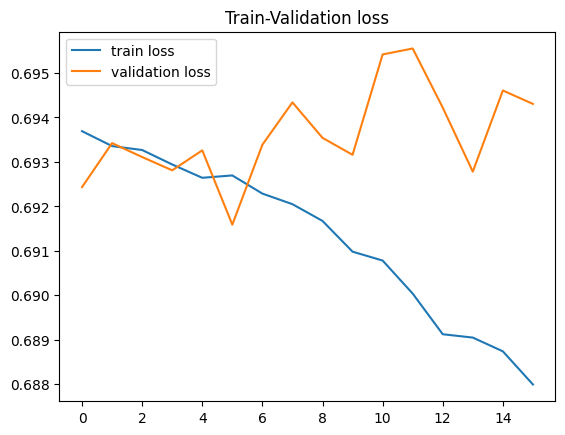

In [35]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [36]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.4525, 'male': 0.6197916666666666, 'average': 0.5361458333333333}
precision {'female': 0.5535168195718655, 'male': 0.5207877461706784, 'average': 0.5371522828712719}
f1 {'female': 0.4979367262723522, 'male': 0.5659928656361474, 'average': 0.5319647959542497}
accuracy 0.5344387755102041


Evaluación en el conjunto el conjunto to
recall {'female': 0.3858267716535433, 'male': 0.635036496350365, 'average': 0.5104316340019541}
precision {'female': 0.494949494949495, 'male': 0.5272727272727272, 'average': 0.5111111111111111}
f1 {'female': 0.4336283185840708, 'male': 0.576158940397351, 'average': 0.5048936294907109}
accuracy 0.5151515151515151


Evaluación en el conjunto el conjunto as
recall {'female': 0.40161725067385445, 'male': 0.5883838383838383, 'average': 0.4950005445288464}
precision {'female': 0.4775641025641026, 'male': 0.512087912087912, 'average': 0.49482600732600734}
f1 {'female': 0.4363103953147877, 'male': 0.54759

In [37]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.4390180630872911
f1 etiqueta male: 0.40658810991302646
f1 etiqueta female:  0.47144801626155575


TO
Resultado global f1: 0.43743017167086545
f1 etiqueta male: 0.4215002304130339
f1 etiqueta female:  0.45336011292869705


AS
Resultado global f1: 0.438940452269264
f1 etiqueta male: 0.4197175431645674
f1 etiqueta female:  0.4581633613739606


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.5024305555555555
recall etiqueta male: 0.4756944444444444
recall etiqueta female:  0.5291666666666667


TO
Resultado global recall: 0.5063317815200108
recall etiqueta male: 0.49472830494728304
recall etiqueta female:  0.5179352580927384


AS
Resultado global recall: 0.5039364897855464
recall etiqueta male: 0.48316498316498313
recall etiqueta female:  0.5247079964061097


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.4943560795334392
precision etiqueta male: 0.4867659544388594
precision etiqueta female: